In [1]:
!pip install -U sagemaker


DEPRECATION: celery 4.4.0 has a non-standard dependency specifier pytz>dev. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:

!pip show sagemaker


Name: sagemaker
Version: 2.221.1
Summary: Open source library for training and deploying models on Amazon SageMaker.
Home-page: https://github.com/aws/sagemaker-python-sdk/
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /Users/kiptoo/anaconda3/envs/mlmicroservice/lib/python3.11/site-packages
Requires: attrs, boto3, cloudpickle, docker, google-pasta, importlib-metadata, jsonschema, numpy, packaging, pandas, pathos, platformdirs, protobuf, psutil, PyYAML, requests, schema, smdebug-rulesconfig, tblib, tqdm, urllib3
Required-by: 


In [3]:
# Install the required packages
!pip install ipython python-dotenv

# Load the autoreload extension
%load_ext autoreload
%autoreload 2

# Load the dotenv extension
%load_ext dotenv
%dotenv

DEPRECATION: celery 4.4.0 has a non-standard dependency specifier pytz>dev. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of celery or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


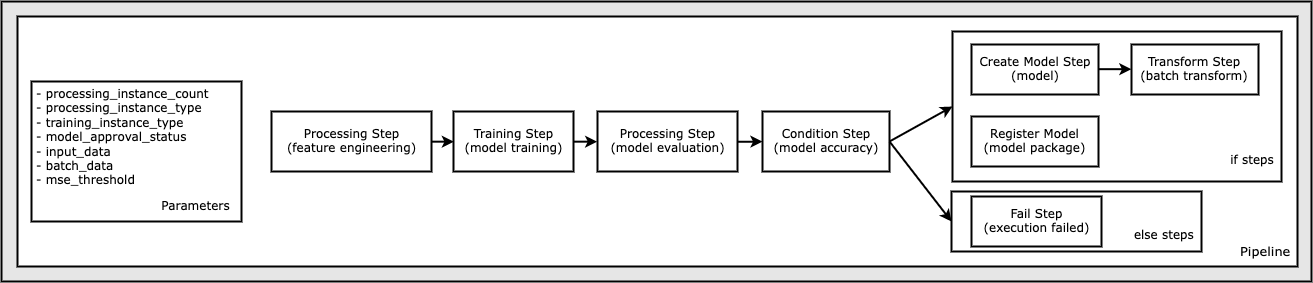

Configuration 

In [9]:
import os
print(f"Role: {os.environ['ROLE']}")
print(f"Bucket: {os.environ['BUCKET']}")
# current_directory = os.getcwd()
# print("Current Working Directory:", current_directory)


Role: arn:aws:iam::956763695025:role/service-role/AmazonSageMaker-ExecutionRole-20231107T213330
Bucket: hillaryabalone


In [10]:
import sys
import os
import boto3
import sagemaker
from sagemaker.workflow.pipeline_context import PipelineSession




sagemaker_session = sagemaker.session.Session()
region = sagemaker_session.boto_region_name
# role = sagemaker.get_execution_role()
role = os.environ["ROLE"]
pipeline_session = PipelineSession()
# default_bucket = sagemaker_session.default_bucket()
default_bucket = os.environ["BUCKET"]
model_package_group_name = f"AbaloneModelPackageGroupName"


In [11]:
print(region)

us-west-2


In [6]:
!mkdir -p data

Uploading data into the default bucket

In [7]:
local_path = "data/abalone-dataset.csv"

s3 = boto3.resource("s3")
s3.Bucket(f"sagemaker-example-files-prod-{region}").download_file(
    "datasets/tabular/uci_abalone/abalone.csv", local_path
)

# local csv is uploaded to AWS Bucket
base_uri = f"s3://{default_bucket}/abalone"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(input_data_uri)

s3://hillaryabalone/abalone/abalone-dataset.csv


This is the data set for batch transformation after model creation 

In [8]:
local_path = "data/abalone-dataset-batch"

s3 = boto3.resource("s3")
s3.Bucket(f"sagemaker-servicecatalog-seedcode-{region}").download_file(
    "dataset/abalone-dataset-batch", local_path
)

base_uri = f"s3://{default_bucket}/abalone"
batch_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)

print(batch_data_uri)

s3://hillaryabalone/abalone/abalone-dataset-batch


Define parameters

In [9]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
    ParameterFloat,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)
instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.m5.xlarge")
model_approval_status = ParameterString(
    name="ModelApprovalStatus", default_value="PendingManualApproval"
)
input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)
batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)
mse_threshold = ParameterFloat(name="MseThreshold", default_value=6.0)

Defining the processing step for feature engineering. 
The first step  preprocessing scrip. 
The preprocessing script uses scikit-learn to do the following:
    Fill in missing sex category data and encode it so that it is suitable for training.
    Scale and normalize all numerical fields, aside from sex and rings numerical data.
    Split the data into training, validation, and test datasets.


In [10]:
%%writefile code/preprocessing.py
# The line above writes the following code to a file named preprocessing.py in the code directory.
# Processing Step for Feature Engineering 
# High-Level Overview
# Imports: Import necessary libraries for data manipulation, handling, and preprocessing.
# Column Names and Data Types: Define the column names and data types for the dataset.
# Utility Function: Define a helper function to merge dictionaries.
# Main Script: Read the dataset, preprocess the data, and split it into training, validation, and test sets.
#                        Summary 
# This script performs data preprocessing, including:
#   Reading and merging data.
#   Handling missing values.
#   Scaling numerical features.
#   Encoding categorical features.
#   Splitting the data into training, validation, and test sets.
#   The preprocessing steps ensure that the data is clean and in a suitable format for training machine learning models.


# numpy and pandas for data manipulation 
# scikit-learn for preprocessing 
import argparse
import os
import requests
import tempfile

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


# Since we get a headerless CSV file, we specify the column names here.
# Defining the column names and data types for the dataset. feature_columns_names contains 
# the names of the feature columns, and label_column contains the name of the target column.
# Feature_columns_dtype and label_column_dtype define the data types for these columns.

feature_columns_names = [
    "sex",
    "length",
    "diameter",
    "height",
    "whole_weight",
    "shucked_weight",
    "viscera_weight",
    "shell_weight",
]
label_column = "rings"

feature_columns_dtype = {
    "sex": str,
    "length": np.float64,
    "diameter": np.float64,
    "height": np.float64,
    "whole_weight": np.float64,
    "shucked_weight": np.float64,
    "viscera_weight": np.float64,
    "shell_weight": np.float64,
}
label_column_dtype = {"rings": np.float64}

# Utility function 
# This function merges two dictionaries. It is used to combine feature_columns_dtype and label_column_dtype.
def merge_two_dicts(x, y):
    z = x.copy()
    z.update(y)
    return z

# Main Script 
# reads the Abalone dataset from a specified directory. It assumes the dataset is in CSV format without headers,
# so it assigns the column names and data types defined earlier.

if __name__ == "__main__":
    base_dir = "/opt/ml/processing"
    

    df = pd.read_csv(
        f"{base_dir}/input/abalone-dataset.csv",
        header=None,
        names=feature_columns_names + [label_column],
        dtype=merge_two_dicts(feature_columns_dtype, label_column_dtype),
    )

# The script separates numeric and categorical features. Numeric features are preprocessed with a pipeline that imputes missing values using the median and scales the features using StandardScaler.
# Categorical features are preprocessed with a pipeline that imputes missing values with "missing" and encodes the categories using OneHotEncoder.
# ColumnTransformer applies these transformations to the respective columns.

    numeric_features = list(feature_columns_names)
    numeric_features.remove("sex")
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
    )

    categorical_features = ["sex"]
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
    )

    preprocess = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

# Splitting and saving the data 
# The target column (rings) is separated from the features.
# The features are transformed using the preprocessing pipeline.
# The target and transformed features are concatenated back together.
# The data is shuffled and split into training (70%), validation (15%), and test (15%) sets.
# These sets are saved as CSV files to the specified directories.

    y = df.pop("rings")
    X_pre = preprocess.fit_transform(df)
    y_pre = y.to_numpy().reshape(len(y), 1)

    X = np.concatenate((y_pre, X_pre), axis=1)

    np.random.shuffle(X)
    train, validation, test = np.split(X, [int(0.7 * len(X)), int(0.85 * len(X))])
# note train, validation test files
    pd.DataFrame(train).to_csv(f"{base_dir}/train/train.csv", header=False, index=False)
    pd.DataFrame(validation).to_csv(
        f"{base_dir}/validation/validation.csv", header=False, index=False
    )
    pd.DataFrame(test).to_csv(f"{base_dir}/test/test.csv", header=False, index=False)

Overwriting code/preprocessing.py


create an instance of a SKLearnProcessor processor and use that in our ProcessingStep.

In [11]:
# SKLearnProcessor provides tools for building, training, and deploying machine learning models.

from sagemaker.sklearn.processing import SKLearnProcessor


framework_version = "1.2-1"

sklearn_processor = SKLearnProcessor(
    framework_version=framework_version,
    instance_type="ml.m5.xlarge",
    instance_count=processing_instance_count,
    base_job_name="sklearn-abalone-process",
    role=role,
    sagemaker_session=pipeline_session,
)

Take the output of the processor’s run method and pass that as arguments to the ProcessingStep
Note the "train_data" and "test_data" named channels specified in the output configuration for the processing job.

In [12]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep

processor_args = sklearn_processor.run(
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
#    this the code in local directory the code didn't execute yet all hapening latter
    code="code/preprocessing.py",
)

step_process = ProcessingStep(name="AbaloneProcess", step_args=processor_args)

/Users/kiptoo/anaconda3/envs/mlmicroservice/lib/python3.11/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(


Defining A Training Step tp Train The Model  
Use Amazon SageMaker’s XGBoost Algorithm to train on this dataset. Configure an Estimator for the XGBoost algorithm and the input dataset. A typical training script loads data from the input channels, configures training with hyperparameters, trains a model, and saves a model to model_dir so that it can be hosted later.
Important estimator is used

image_uri - is like an address/link to blueprint that includes tools/libraries needed to run XGBoost


In [13]:
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput

# model path for training
model_path = f"s3://{default_bucket}/AbaloneTrain"
image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.0-1",
    py_version="py3",
    instance_type="ml.m5.xlarge",
)
xgb_train = Estimator(
    image_uri=image_uri,
    instance_type=instance_type,
    instance_count=1,
    output_path=model_path,
    role=role,
    sagemaker_session=pipeline_session,
)
xgb_train.set_hyperparameters(
    objective="reg:linear",
    num_round=50,
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.7,
)
# output of the Estmator .fit() method as arguments to he Training step
train_args = xgb_train.fit(
    inputs={
        "train": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
            content_type="text/csv",
        ),
        "validation": TrainingInput(
            s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                "validation"
            ].S3Output.S3Uri,
            content_type="text/csv",
        ),
    }
)

In [14]:
# Setting up the training step ('step_train') name of the step is 'AbaloneTrain'

In [15]:
from sagemaker.inputs import TrainingInput
from sagemaker.workflow.steps import TrainingStep


step_train = TrainingStep(
    name="AbaloneTrain",
    step_args=train_args,
)

Model evaluation step to evaluate the trained model
Load the model.
Read the test data.
Issue predictions against the test data.
Build a classification report, including accuracy and ROC curve.
Save the evaluation report to the evaluation directory.

In [16]:
%%writefile code/evaluation.py
import json
import pathlib
import pickle
import tarfile

import joblib
import numpy as np
import pandas as pd
import xgboost

from sklearn.metrics import mean_squared_error


if __name__ == "__main__":
    model_path = f"/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = pickle.load(open("xgboost-model", "rb"))

    test_path = "/opt/ml/processing/test/test.csv"
    df = pd.read_csv(test_path, header=None)

    y_test = df.iloc[:, 0].to_numpy()
    df.drop(df.columns[0], axis=1, inplace=True)

    X_test = xgboost.DMatrix(df.values)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {"value": mse, "standard_deviation": std},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))


Overwriting code/evaluation.py


Creating instance of a ScriptProcessor

In [17]:
from sagemaker.processing import ScriptProcessor


script_eval = ScriptProcessor(
    image_uri=image_uri,
    command=["python3"],
    instance_type="ml.m5.xlarge",
    instance_count=1,
    base_job_name="script-abalone-eval",
    role=role,
    sagemaker_session=pipeline_session,
)

eval_args = script_eval.run(
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_process.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="code/evaluation.py",
)

Use the processor’s arguments returned by .run() to construct a ProcessingStep, 
along with the input and output channels and the code that will be executed when the pipeline invokes pipeline execution.

In [18]:
from sagemaker.workflow.properties import PropertyFile


evaluation_report = PropertyFile(
    name="EvaluationReport", output_name="evaluation", path="evaluation.json"
)
step_eval = ProcessingStep(
    name="AbaloneEval",
    step_args=eval_args,
    property_files=[evaluation_report],
)

Define a Create Model Step to Create a Model 
In order to perform batch transformation ???????? why batch is comming up here

In [19]:
from sagemaker.model import Model


model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

In [20]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.model_step import ModelStep

step_create_model = ModelStep(
    name="AbaloneCreateModel",
    step_args=model.create(instance_type="ml.m5.large", accelerator_type="ml.eia1.medium"),
)

Defining a transform Step to Perform Batch Transformation 
Now that a model instance is defined, create a Transformer instance with the appropriate model type, compute instance type, and desired output S3 URI.

In [21]:
from sagemaker.transformer import Transformer


transformer = Transformer(
    model_name=step_create_model.properties.ModelName,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    output_path=f"s3://{default_bucket}/AbaloneTransform",
)

Passing in the transformer instance and the TransformInput with the batch_data pipeline parameter defined earlier.
where/how  do I look up sagemaker librarries ???? 

In [22]:
from sagemaker.inputs import TransformInput
from sagemaker.workflow.steps import TransformStep


step_transform = TransformStep(
    name="AbaloneTransform", transformer=transformer, inputs=TransformInput(data=batch_data)
)

Define a Register Model Step to Create Model Step to Create A Model Package 

Registarng model created in the previos step

In [23]:
model = Model(
    image_uri=image_uri,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

We take the outputs of the .register() call and pass that to the ModelStep as step arguments.

In [24]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json",
    )
)

register_args = model.register(
    content_types=["text/csv"],
    response_types=["text/csv"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=model_package_group_name,
    approval_status=model_approval_status,
    model_metrics=model_metrics,
)
step_register = ModelStep(name="AbaloneRegisterModel", step_args=register_args)

Defining a Fail Step to Terminate the Pipeline Execution and Mark as Failed

In [25]:
from sagemaker.workflow.fail_step import FailStep
from sagemaker.workflow.functions import Join

step_fail = FailStep(
    name="AbaloneMSEFail",
    error_message=Join(on=" ", values=["Execution failed due to MSE >", mse_threshold]),
)

Define a Condition Step to Check Accuracy and Conditionally Create a Model and Run a Batch Transformation and Register a Model in the Model Registry, Or Terminate the Execution in Failed State 
In this step, the model is registered only if the accuracy of the model, as determined by the evaluation step step_eval, exceeded a specified value. Otherwise, the pipeline execution fails and terminates.

In [26]:
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


cond_lte = ConditionLessThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=evaluation_report,
        json_path="regression_metrics.mse.value",
    ),
    right=mse_threshold,
)

step_cond = ConditionStep(
    name="AbaloneMSECond",
    conditions=[cond_lte],
    if_steps=[step_register, step_create_model, step_transform],
    else_steps=[step_fail],
)

Define a Pipeline of Parameters, Steps and Conditions
In this section, combine the steps into a Pipeline so it can be executed.


In [27]:
from sagemaker.workflow.pipeline import Pipeline


pipeline_name = f"AbalonePipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_count,
        instance_type,
        model_approval_status,
        input_data,
        batch_data,
        mse_threshold,
    ],
    steps=[step_process, step_train, step_eval, step_cond],
)

Optional Exxamine pipeline definition

In [28]:
import json


definition = json.loads(pipeline.definition())
definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceCount',
   'Type': 'Integer',
   'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.m5.xlarge'},
  {'Name': 'ModelApprovalStatus',
   'Type': 'String',
   'DefaultValue': 'PendingManualApproval'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://hillaryabalone/abalone/abalone-dataset.csv'},
  {'Name': 'BatchData',
   'Type': 'String',
   'DefaultValue': 's3://hillaryabalone/abalone/abalone-dataset-batch'},
  {'Name': 'MseThreshold', 'Type': 'Float', 'DefaultValue': 6.0}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'AbaloneProcess',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.xlarge',
      'InstanceCount': {'Get': 'Parameters.ProcessingInstanceCount'},
  

Submit the pipeline to SageMaker and start execution

In [29]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:956763695025:pipeline/AbalonePipeline',
 'ResponseMetadata': {'RequestId': '31ca0830-dbab-45ed-8933-d48db6d207d3',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '31ca0830-dbab-45ed-8933-d48db6d207d3',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '83',
   'date': 'Mon, 27 May 2024 14:25:12 GMT'},
  'RetryAttempts': 0}}

Start the pipeline and accpet all default parameters

In [30]:
execution = pipeline.start()

Describe the pipeline execution 

In [31]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-west-2:956763695025:pipeline/AbalonePipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-west-2:956763695025:pipeline/AbalonePipeline/execution/iw8htrmeczkx',
 'PipelineExecutionDisplayName': 'execution-1716819914146',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2024, 5, 27, 17, 25, 14, 61000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2024, 5, 27, 17, 25, 14, 61000, tzinfo=tzlocal()),
 'CreatedBy': {'IamIdentity': {'Arn': 'arn:aws:iam::956763695025:root',
   'PrincipalId': '956763695025'}},
 'LastModifiedBy': {'IamIdentity': {'Arn': 'arn:aws:iam::956763695025:root',
   'PrincipalId': '956763695025'}},
 'ResponseMetadata': {'RequestId': '2dd300b1-89ad-4392-8fc9-45a1ea8fbd0e',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2dd300b1-89ad-4392-8fc9-45a1ea8fbd0e',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '561',
   'date': 'Mon, 27 May 2024 14:25:13 GMT'},


Wait for the execution to complete

In [32]:
execution.wait()

List the steps in the execution. These are the steps in the pipeline that have been resolved by the step executor service.

In [33]:
execution.list_steps()

[{'StepName': 'AbaloneTransform',
  'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 48, 789000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 5, 27, 17, 39, 47, 913000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'TransformJob': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:transform-job/pipelines-iw8htrmeczkx-AbaloneTransform-yrxyyZO4Op'}},
  'AttemptCount': 1},
 {'StepName': 'AbaloneRegisterModel-RegisterModel',
  'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 46, 999000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 5, 27, 17, 34, 48, 37000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:model-package/AbaloneModelPackageGroupName/4'}},
  'AttemptCount': 1},
 {'StepName': 'AbaloneCreateModel-CreateModel',
  'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 46, 999000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2024, 5, 27, 17, 34, 48, 56000, 

Examine The Evaluation 
Examine the resulting model evaluation after the pipeline completes. Download the resulting evaluation.json file from S3 and print the report.

from pprint import pprint


evaluation_json = sagemaker.s3.S3Downloader.read_file(
    "{}/evaluation.json".format(
        step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
    )
)
pprint(json.loads(evaluation_json))

Review the lineage of the artifacts generated by the pipeline.

In [34]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer


viz = LineageTableVisualizer(sagemaker.session.Session())
for execution_step in reversed(execution.list_steps()):
    print(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

{'StepName': 'AbaloneProcess', 'StartTime': datetime.datetime(2024, 5, 27, 17, 25, 14, 994000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 30, 6, 908000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:processing-job/pipelines-iw8htrmeczkx-AbaloneProcess-BYrDI6o0m4'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...167ca7b0c3d30dac5f59ec6/preprocessing.py,Input,DataSet,ContributedTo,artifact
1,s3://hillaryabalone/abalone/abalone-dataset.csv,Input,DataSet,ContributedTo,artifact
2,24661...com/sagemaker-scikit-learn:1.2-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://.../iw8htrmeczkx/AbaloneProcess/output/test,Output,DataSet,Produced,artifact
4,s3://...rmeczkx/AbaloneProcess/output/validation,Output,DataSet,Produced,artifact
5,s3://...iw8htrmeczkx/AbaloneProcess/output/train,Output,DataSet,Produced,artifact


{'StepName': 'AbaloneTrain', 'StartTime': datetime.datetime(2024, 5, 27, 17, 30, 7, 762000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 32, 11, 522000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:training-job/pipelines-iw8htrmeczkx-AbaloneTrain-2LoGrIds9L'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...rmeczkx/AbaloneProcess/output/validation,Input,DataSet,ContributedTo,artifact
1,s3://...iw8htrmeczkx/AbaloneProcess/output/train,Input,DataSet,ContributedTo,artifact
2,24661...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...loneTrain-2LoGrIds9L/output/model.tar.gz,Output,Model,Produced,artifact


{'StepName': 'AbaloneEval', 'StartTime': datetime.datetime(2024, 5, 27, 17, 32, 12, 235000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 34, 44, 989000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:processing-job/pipelines-iw8htrmeczkx-AbaloneEval-L6OoK8bsv1'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...1efdc9e2d552feb7e97dadd942/evaluation.py,Input,DataSet,ContributedTo,artifact
1,s3://.../iw8htrmeczkx/AbaloneProcess/output/test,Input,DataSet,ContributedTo,artifact
2,s3://...loneTrain-2LoGrIds9L/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,24661...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...024-05-27-14-24-58-244/output/evaluation,Output,DataSet,Produced,artifact


{'StepName': 'AbaloneMSECond', 'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 46, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 34, 46, 558000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Condition': {'Outcome': 'True'}}, 'AttemptCount': 1}


None

{'StepName': 'AbaloneCreateModel-CreateModel', 'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 46, 999000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 34, 48, 56000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:model/pipelines-iw8htrmeczkx-AbaloneCreateModel-C-kiDSYHrvoM'}}, 'AttemptCount': 1}


None

{'StepName': 'AbaloneRegisterModel-RegisterModel', 'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 46, 999000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 34, 48, 37000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:model-package/AbaloneModelPackageGroupName/4'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...loneTrain-2LoGrIds9L/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,24661...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
2,AbaloneModelPackageGroupName-4-PendingManualAp...,Input,Approval,ContributedTo,action
3,AbaloneModelPackageGroupName-1715421215-aws-mo...,Output,ModelGroup,AssociatedWith,context


{'StepName': 'AbaloneTransform', 'StartTime': datetime.datetime(2024, 5, 27, 17, 34, 48, 789000, tzinfo=tzlocal()), 'EndTime': datetime.datetime(2024, 5, 27, 17, 39, 47, 913000, tzinfo=tzlocal()), 'StepStatus': 'Succeeded', 'Metadata': {'TransformJob': {'Arn': 'arn:aws:sagemaker:us-west-2:956763695025:transform-job/pipelines-iw8htrmeczkx-AbaloneTransform-yrxyyZO4Op'}}, 'AttemptCount': 1}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...loneTrain-2LoGrIds9L/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,24661...naws.com/sagemaker-xgboost:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
2,s3://...aryabalone/abalone/abalone-dataset-batch,Input,DataSet,ContributedTo,artifact
3,s3://hillaryabalone/AbaloneTransform,Output,DataSet,Produced,artifact
